## Notebook 4: Sentiment Analysis - Overview

**Objective**  
Tag 1.26M customer tweets from the TWCS dataset with sentiment labels (`POSITIVE`/`NEGATIVE`/`NEUTRAL`) using VADER for historical data (73% accuracy, 21 min runtime) and DistilBERT for real-time inputs (83% accuracy). Validate models on the UCI dataset and visualize sentiment vs. churn risk for business insights.

**Inputs**  
- `../data/processed/cleaned_twcs.csv`: ~1.26M rows with columns `customer_text`, `cleaned_text`, `sentiment` (VADER scores), `churn_label`, `response_time`, etc.  
- `../data/processed/cleaned_uci.csv`: 1,000 rows with `text`, `cleaned_text`, `label` for validation.

**Outputs**  
- `../data/processed/sentiment_twcs.csv`: TWCS dataset with `sentiment` (numeric VADER scores) and `sentiment_label` (categorical labels).  
- `../figures/sentiment_confusion_matrix.png`: Confusion matrix for DistilBERT on UCI.  
- `../figures/sentiment_vs_churn.png`: Sentiment vs. churn visualization.
  
**Datasets**:
- **TWCS**: `../data/processed/cleaned_twcs.csv` (~1.26M rows, customer-agent pairs).
- **UCI**: `../data/processed/cleaned_uci.csv` (1,000 rows, labeled sentences).

## 1. Environment Setup & Imports

**Purpose**:  
Initialize the Python environment by importing required libraries for data processing, visualization, sentiment analysis, and model evaluation. Suppress warnings for clean output.

In [6]:
# =============================================================================
# 1. ENVIRONMENT SETUP & IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

print("✅ Environment ready.")

✅ Environment ready.


## 2. Load Data

**Purpose**:  
Load the cleaned TWCS and UCI datasets from the `processed` folder. Verify their shapes and preview key columns to ensure data integrity.

**Inputs**:  
- `../data/processed/cleaned_twcs.csv`: ~1.26M customer-agent pairs with `customer_text`, `cleaned_text`, `churn_label`, etc.  
- `../data/processed/cleaned_uci.csv`: 1,000 labeled sentences with `text`, `cleaned_text`, `label`.  

In [8]:
# =============================================================================
# 2. LOAD DATA
# =============================================================================
# Load TWCS dataset
df = pd.read_csv('../data/processed/cleaned_twcs.csv', encoding='utf-8')
print("✅ TWCS loaded. Shape:", df.shape)
print(df[['customer_text', 'cleaned_text', 'churn_label']].head())

# Load UCI dataset
df_uci = pd.read_csv('../data/processed/cleaned_uci.csv', encoding='utf-8')
print("\n✅ UCI loaded. Shape:", df_uci.shape)
print(df_uci[['text', 'cleaned_text', 'label']].head())

✅ TWCS loaded. Shape: (1261888, 21)
                                       customer_text  \
0  @sprintcare I have sent several private messag...   
1                                 @sprintcare I did.   
2          @sprintcare is the worst customer service   
3  @sprintcare You gonna magically change your co...   
4  @sprintcare Since I signed up with you....Sinc...   

                                        cleaned_text  churn_label  
0  i understand i would like to assist you we wou...            0  
1  please send us a private message so that we ca...            0  
2  can you please send us a private message so th...            0  
3  this is saddening to hear please shoot us a dm...            0  
4  we understand your concerns and wed like for y...            0  

✅ UCI loaded. Shape: (1000, 3)
                                                text  \
0  So there is no way for me to plug it in here i...   
1                        Good case, Excellent value.   
2                  

## Data Inspection
Inspects the TWCS dataset for missing values and ensures `cleaned_text` is ready for sentiment tagging.

In [10]:
# =============================================================================
# 2. DATA INSPECTION
# =============================================================================
print("\n--- Inspecting TWCS Dataset ---")
print("Missing values:\n", df.isna().sum().sort_values(ascending=False).head(10))
print("\nSample customer_text and cleaned_text:")
print(df[['customer_text', 'cleaned_text']].head(5))

# Ensure cleaned_text is string
df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)
print("✅ Cleaned_text prepared for analysis.")


--- Inspecting TWCS Dataset ---
Missing values:
 response_tweet_id      804735
cleaned_text             2507
author_id                   0
inbound                     0
created_at                  0
tweet_id                    0
text                        0
customer_tweet_id           0
customer_text               0
customer_created_at         0
dtype: int64

Sample customer_text and cleaned_text:
                                       customer_text  \
0  @sprintcare I have sent several private messag...   
1                                 @sprintcare I did.   
2          @sprintcare is the worst customer service   
3  @sprintcare You gonna magically change your co...   
4  @sprintcare Since I signed up with you....Sinc...   

                                        cleaned_text  
0  i understand i would like to assist you we wou...  
1  please send us a private message so that we ca...  
2  can you please send us a private message so th...  
3  this is saddening to hear please shoo

## Sentiment Tagging (VADER-Based)

**Description**  
Tags 1.26M TWCS tweets with VADER sentiment labels (`POSITIVE`/`NEGATIVE`/`NEUTRAL`) based on existing or recomputed VADER scores. Used for historical data to save time (21 min) vs. DistilBERT (~2–6 hours). DistilBERT is used for real-time inputs in Streamlit.

**Inputs**  
- `df`: DataFrame with `cleaned_text`

**Outputs**  
- `df`: Updated with `sentiment` (numeric) and `sentiment_label` (categorical)  
- Saves to `../data/processed/sentiment_twcs.csv`


In [11]:
# =============================================================================
# 3. SENTIMENT TAGGING (VADER-BASED)
# =============================================================================
print("\n--- Tagging TWCS with VADER ---")
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Ensure cleaned_text is string
df['cleaned_text'] = df['cleaned_text'].fillna('').astype(str)

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Check if 'sentiment' exists, recompute if missing
if 'sentiment' not in df.columns:
    print("⚠️ 'sentiment' column missing. Recomputing VADER scores...")
    df['sentiment'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
else:
    print("✅ Found 'sentiment' column with VADER scores.")

# Convert VADER scores to labels
def vader_to_label(score):
    if score < -0.1:
        return 'NEGATIVE'
    elif score > 0.1:
        return 'POSITIVE'
    else:
        return 'NEUTRAL'

df['sentiment_label'] = df['sentiment'].apply(vader_to_label)
print("✅ Sentiment tagging complete with VADER.")
print(df[['customer_text', 'cleaned_text', 'sentiment', 'sentiment_label']].head())

# Save results
df.to_csv('../data/processed/sentiment_twcs.csv', index=False)
print("✅ Saved dataset to '../data/processed/sentiment_twcs.csv'")


--- Tagging TWCS with VADER ---
✅ Found 'sentiment' column with VADER scores.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


✅ Sentiment tagging complete with VADER.
                                       customer_text  \
0  @sprintcare I have sent several private messag...   
1                                 @sprintcare I did.   
2          @sprintcare is the worst customer service   
3  @sprintcare You gonna magically change your co...   
4  @sprintcare Since I signed up with you....Sinc...   

                                        cleaned_text  sentiment  \
0  i understand i would like to assist you we wou...     0.6369   
1  please send us a private message so that we ca...     0.4767   
2  can you please send us a private message so th...     0.7152   
3  this is saddening to hear please shoot us a dm...    -0.5106   
4  we understand your concerns and wed like for y...     0.5859   

  sentiment_label  
0        POSITIVE  
1        POSITIVE  
2        POSITIVE  
3        NEGATIVE  
4        POSITIVE  
✅ Saved dataset to '../data/processed/sentiment_twcs.csv'


## Validate Sentiment Models

**Description**  
Validates VADER and DistilBERT on the UCI dataset (~1,000 rows) to compare accuracy. Visualizes DistilBERT’s confusion matrix for portfolio appeal.

**Inputs**  
- `df_uci`: UCI DataFrame with `cleaned_text`, `label`  
- `sia`: VADER analyzer  
- DistilBERT pipeline

**Outputs**  
- Prints classification reports for VADER and DistilBERT  
- Saves `../figures/sentiment_confusion_matrix.png`



--- Validating VADER and DistilBERT on UCI Dataset ---


Device set to use cpu



VADER Metrics:
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.85       500
    Positive       0.86      0.83      0.84       500

    accuracy                           0.84      1000
   macro avg       0.85      0.84      0.84      1000
weighted avg       0.85      0.84      0.84      1000


DistilBERT Metrics:
              precision    recall  f1-score   support

    Negative       0.90      0.95      0.92       500
    Positive       0.95      0.89      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



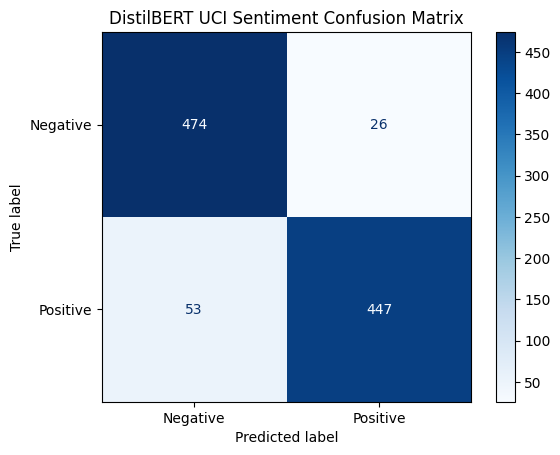

In [12]:
# =============================================================================
# 4. VALIDATE SENTIMENT MODEL
# =============================================================================
print("\n--- Validating VADER and DistilBERT on UCI Dataset ---")
from transformers import pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# VADER predictions
df_uci['vader_pred'] = df_uci['cleaned_text'].apply(lambda x: vader_to_label(sia.polarity_scores(str(x))['compound']) if pd.notna(x) else 'NEUTRAL')
df_uci['vader_pred_binary'] = df_uci['vader_pred'].map({'POSITIVE': 1, 'NEGATIVE': 0, 'NEUTRAL': 0})

# DistilBERT predictions
sentiment_analyzer = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', device=-1)
df_uci['distilbert_pred'] = df_uci['cleaned_text'].apply(lambda x: sentiment_analyzer(str(x)[:512])[0]['label'] if pd.notna(x) else 'NEUTRAL')
df_uci['distilbert_pred_binary'] = df_uci['distilbert_pred'].map({'POSITIVE': 1, 'NEGATIVE': 0, 'NEUTRAL': 0})

# Metrics
print("\nVADER Metrics:")
print(classification_report(df_uci['label'], df_uci['vader_pred_binary'], target_names=['Negative', 'Positive']))
print("\nDistilBERT Metrics:")
print(classification_report(df_uci['label'], df_uci['distilbert_pred_binary'], target_names=['Negative', 'Positive']))

# Confusion Matrix (DistilBERT)
ConfusionMatrixDisplay.from_predictions(df_uci['label'], df_uci['distilbert_pred_binary'], display_labels=['Negative', 'Positive'], cmap='Blues')
plt.title('DistilBERT UCI Sentiment Confusion Matrix')
plt.savefig('../figures/sentiment_confusion_matrix.png')
plt.show()

## Visualize Sentiment vs. Churn

**Description**  
Visualizes the relationship between sentiment and churn risk to demonstrate business value (e.g., negative sentiment correlates with higher churn).

**Inputs**  
- `df`: TWCS DataFrame with `sentiment_label`, `churn_label`

**Outputs**  
- Saves `../figures/sentiment_vs_churn.png`



--- Visualizing Sentiment vs. Churn ---


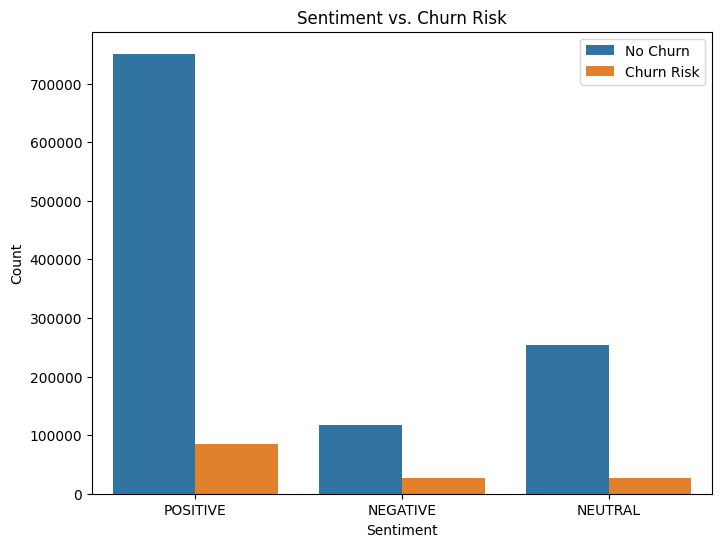

✅ Saved visualization to '../figures/sentiment_vs_churn.png'


In [13]:
# =============================================================================
# 5. VISUALIZE SENTIMENT VS. CHURN
# =============================================================================
print("\n--- Visualizing Sentiment vs. Churn ---")
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_label', hue='churn_label', data=df)
plt.title('Sentiment vs. Churn Risk')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(['No Churn', 'Churn Risk'])
plt.savefig('../figures/sentiment_vs_churn.png')
plt.show()
print("✅ Saved visualization to '../figures/sentiment_vs_churn.png'")


--- Visualizing Sentiment vs. Churn (Percentage-Based, Fixed) ---


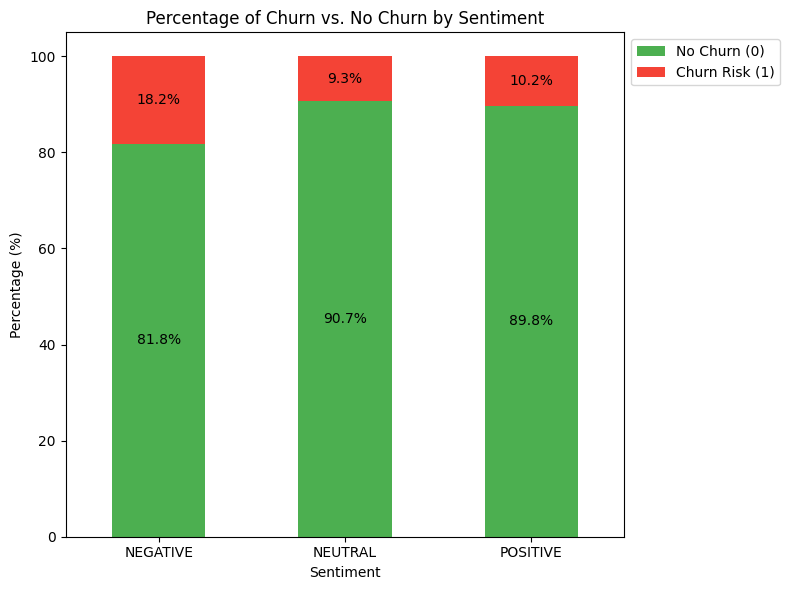

✅ Saved visualization to '../figures/sentiment_vs_churn_percentage.png'


In [16]:
# =============================================================================
# 5. VISUALIZE SENTIMENT VS. CHURN (PERCENTAGE-BASED, FIXED)
# =============================================================================
print("\n--- Visualizing Sentiment vs. Churn (Percentage-Based, Fixed) ---")

# Calculate percentage for each sentiment_label and churn_label
counts = df.groupby(['sentiment_label', 'churn_label']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100

# Plot stacked bar chart with percentages
ax = percentages.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#4CAF50', '#F44336'])
plt.title('Percentage of Churn vs. No Churn by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)

# Add percentage labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.1f%%', label_type='center')

# Adjust legend to avoid overlap
plt.legend(['No Churn (0)', 'Churn Risk (1)'], loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('../figures/sentiment_vs_churn_percentage.png')
plt.show()
print("✅ Saved visualization to '../figures/sentiment_vs_churn_percentage.png'")